**Μέρος 1ο: Ψυχοακουστικό Μοντέλο 1**

***Βήμα 1.0:*** Προεπεξεργασία του σήματος

Θα δημιουργήσουμε 3 συναρτήσεις για καθένα από τα 3 υποερωτήματα του βήματος. Αρχικά, φορτώνουμε το αρχείο "music.wav" χρησιμοποιώντας τη συνάρτηση *read_wav_file*. Αυτή, καλεί τόσο τη συνάρτηση *convert_to_mono*, η οποία μετατρέπει το σήμα από stereo σε mono format, όσο και τη συνάρτηση *normalize_signal*, η οποία κανονικοποιεί το δείγμα όπως ζητείται. Τέλος, απεικονίζουμε το σήμα.

Sample Rate: 44100
Normalized Data: [-0.02382895  0.02011556  0.06694087  0.10487403  0.12212546  0.12345761
  0.12239189  0.13889398  0.17847568  0.21547633]


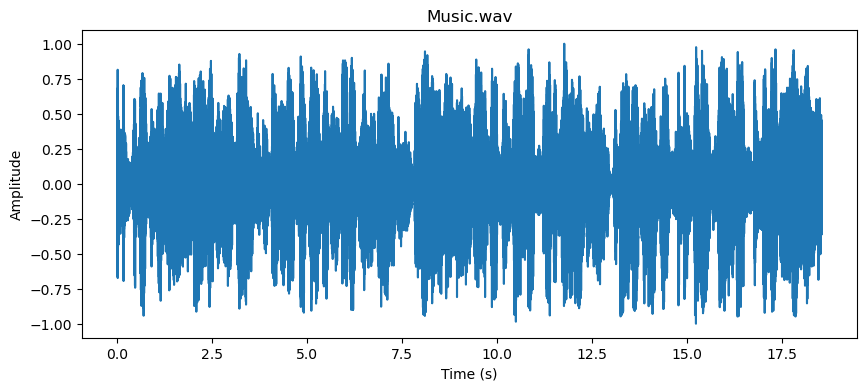

Number of Frames: 1597
Frame Length: 512


In [34]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.signal import hamming
import math
from scipy.fft import fft
import os

def convert_to_mono(wav_data):
    if wav_data.ndim == 2:
        return np.mean(wav_data, axis=1)
    return wav_data

def normalize_signal(wav_data):
    max_val = np.max(np.abs(wav_data))
    return wav_data / max_val

def read_wav_file(filename):
    sample_rate, wav_data = wavfile.read(filename)
    mono_data = convert_to_mono(wav_data)
    normalized_data = normalize_signal(mono_data)
    return sample_rate, normalized_data

cwd = os.getcwd()
filename = os.path.join(cwd, 'music.wav')
sample_rate, normalized_data = read_wav_file(filename)

# Print the sample rate and the first 10 samples of the normalized data to check if they are between the values [-1,1]
print("Sample Rate:", sample_rate)
print("Normalized Data:", normalized_data[:10])

# Plotting the input file data
time = np.arange(0, len(normalized_data)) / sample_rate

plt.figure(figsize=(10, 4))
plt.plot(time, normalized_data)
plt.title('Music.wav')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

def window_signal(signal, window_size):
    num_frames = len(signal) // window_size
    frames = np.zeros((num_frames, window_size))

    for i in range(num_frames):
        start = i * window_size
        end = start + window_size
        frames[i] = signal[start:end] * hamming(window_size)

    return frames

window_size = 512
windowed_frames = window_signal(normalized_data, window_size)

# Get the shape information
num_frames = len(windowed_frames)
frame_length = len(windowed_frames[0])

print("Number of Frames:", num_frames)
print("Frame Length:", frame_length)

***Βήμα 1.1:*** Φασματική Ανάλυση

Σε αυτόν τον κώδικα, η συνάρτηση bark_scale υπολογίζει τις τιμές κλίμακας Bark για μια δεδομένη συχνότητα σύμφωνα με την παρεχόμενη εξίσωση. Η συνάρτηση calculate_power_spectrum λαμβάνει το σήμα και το μέγεθος του παραθύρου ως εισόδους και υπολογίζει το φάσμα ισχύος χρησιμοποιώντας ένα παράθυρο Hanning και την εξίσωση μονόπλευρου φάσματος ισχύος που μας δίνεται.

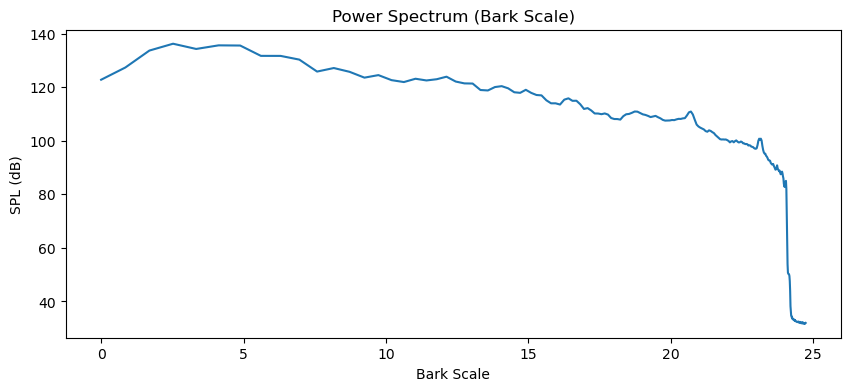

In [35]:
def bark_scale(frequency):
    return 13 * np.arctan(0.00076 * frequency) + 3.5 * np.arctan((frequency / 7500) ** 2)

def calculate_power_spectrum(signal, window_size):
    hann_window = 0.5 * (1 - np.cos(2 * np.pi * np.arange(window_size) / window_size))
    normalization_constant = 90.302

    signal_length = len(signal)
    num_windows = signal_length // window_size

    spectrum = np.zeros(window_size // 2)

    for i in range(num_windows):
        start = i * window_size
        end = start + window_size
        windowed_signal = signal[start:end] * hann_window

        spectrum += np.abs(fft(windowed_signal))[:window_size // 2]

    spectrum /= num_windows

    power_spectrum = normalization_constant + 10 * np.log10(np.sum(hann_window**2) * spectrum**2)

    return power_spectrum

spectrum = calculate_power_spectrum(normalized_data, window_size)

# Generate frequency axis using the sample rate and window size
frequency_axis = np.fft.fftfreq(window_size, d=1/sample_rate)[:window_size // 2]

# Convert frequency axis to Bark scale
bark_frequency_axis = bark_scale(frequency_axis)

# Plotting the spectrum in units of SPL on the Bark scale
plt.figure(figsize=(10, 4))
plt.plot(bark_frequency_axis, spectrum)
plt.title('Power Spectrum (Bark Scale)')
plt.xlabel('Bark Scale')
plt.ylabel('SPL (dB)')
plt.show()


Αν θελήσουμε να πάρουμε το φάσμα ισχύος του σήματος σε κλίμακα Bark με περισσότερη ακρίβεια, π.χ. για το 10ο, το 30ο και το 50ο πλαίσιο, κάνουμε ορισμένες αλλαγές στη συνάρτηση *calculate_power_spectrum* στον παραπάνω κώδικα και εκτυπώνουμε καθένα από τα παραπάνω πλαίσια του φάσματος ισχύος.

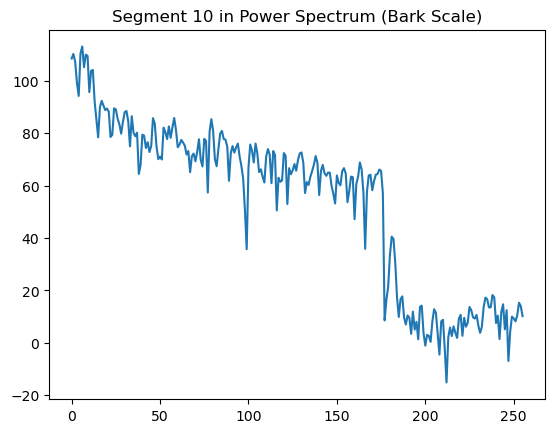

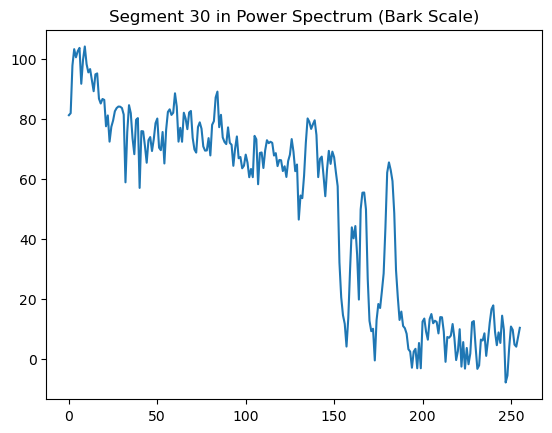

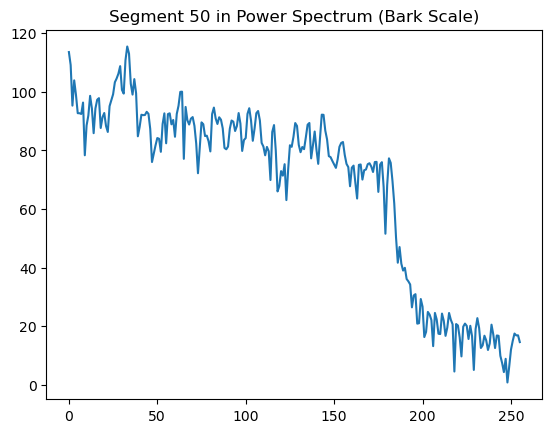

In [36]:
def calculate_power_spectrum(windowed_frames, length):
    def spectrum(signal):
        return 10 * np.log10(abs(np.fft.fft(signal, n=len(signal))) ** 2) + 90.302

    return [spectrum(signal)[0:length // 2] for signal in windowed_frames]

calculate_spectrum = calculate_power_spectrum(windowed_frames, window_size)

plt.title("Segment 10 in Power Spectrum (Bark Scale)")
plt.plot(calculate_spectrum[9]);
plt.show()

plt.title("Segment 30 in Power Spectrum (Bark Scale)")
plt.plot(calculate_spectrum[29]);
plt.show()

plt.title("Segment 50 in Power Spectrum (Bark Scale)")
plt.plot(calculate_spectrum[49]);
plt.show()

***Βήμα 1.2:*** Εντοπισμός μασκών τόνων και θορύβου (Maskers)

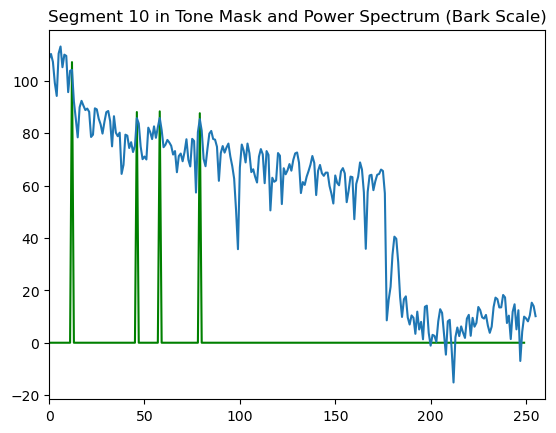

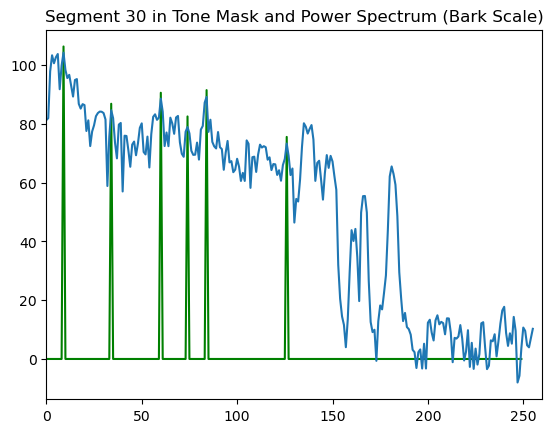

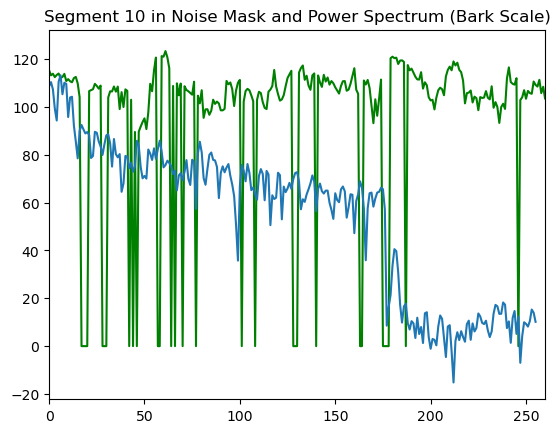

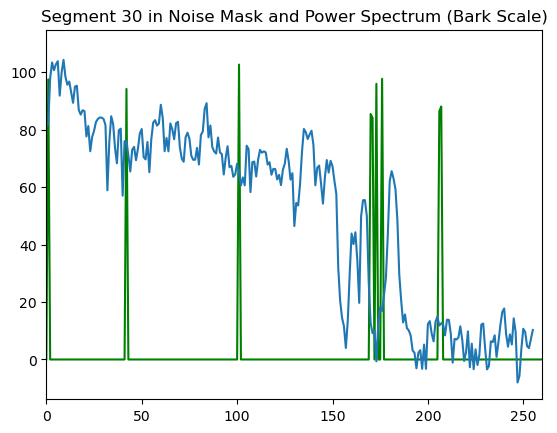

In [37]:
def check_STK(spectrum, length):
    def D_k(k):
        if 2 < k < 63:
            return [2]
        elif 63 <= k < 127:
            return [2, 3]
        elif 127 <= k <= 250:
            return [2, 3, 4, 5, 6]
        return []

    def S_T_k(P, k):
        d_k = D_k(k)
        if 3 <= k <= 250:
            return all(
                P[k] > P[k + 1] and P[k] > P[k - 1] and P[k] > (P[k + d] + 7) and P[k] > (P[k - d] + 7)
                for d in d_k
            )
        return 0

    return [[S_T_k(P, k) for k in range(length // 2 - 6)] for P in spectrum]

def check_P_TM(spectrum, S_T, length):
    P_TM = []
    for i, p in enumerate(spectrum):
        temp = [
            10 * np.log10(
                np.power(10, (0.1 * p[k - 1])) + np.power(10, (0.1 * p[k])) + np.power(10, (0.1 * p[k + 1]))
            ) if S_T[i][k] else 0
            for k in range(length // 2 - 6)
        ]
        P_TM.append(temp)
    return P_TM

spectrum = calculate_power_spectrum(windowed_frames, window_size)

S_T = check_STK(spectrum, window_size)
P_NM = np.load(os.path.join(cwd, 'P_NM-23.npy'))
P_TM = check_P_TM(spectrum, S_T, window_size)

plt.figure(1)
plt.title("Segment 10 in Tone Mask and Power Spectrum (Bark Scale)")
plt.plot(P_TM[9], color='green')
plt.xlim(0, 260)
plt.plot(spectrum[9])

plt.figure(2)
plt.title("Segment 30 in Tone Mask and Power Spectrum (Bark Scale)")
plt.plot(P_TM[29], color='green')
plt.xlim(0, 260)
plt.plot(spectrum[29])

plt.figure(3)
plt.title("Segment 10 in Noise Mask and Power Spectrum (Bark Scale)")
plt.plot(P_NM[9], color='green')
plt.xlim(0, 260)
plt.plot(spectrum[9])

plt.figure(4)
plt.title("Segment 30 in Noise Mask and Power Spectrum (Bark Scale)")
plt.plot(P_NM[29], color='green')
plt.xlim(0, 260)
plt.plot(spectrum[29])

plt.show()

***Βήμα 1.3:*** Μείωση και αναδιοργάνωση των μασκών

Σε αυτό το βήμα θα ακολουθήσουμε την ίδια διαδικασία με το *Βήμα 1.2*, χρησιμοποιώντας διαφορετικά στοιχεία πίνακα P_NMc και P_TMc.

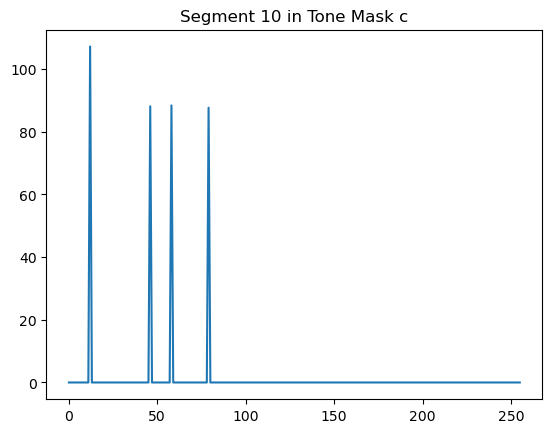

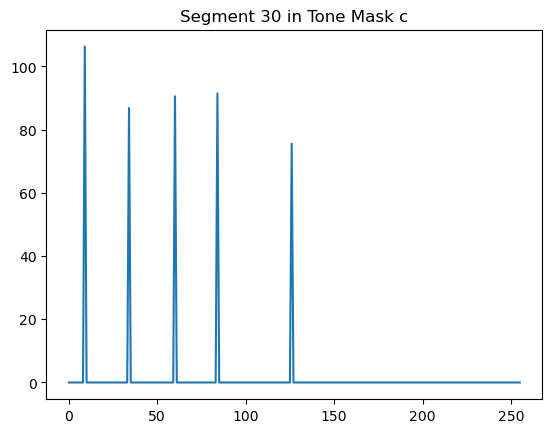

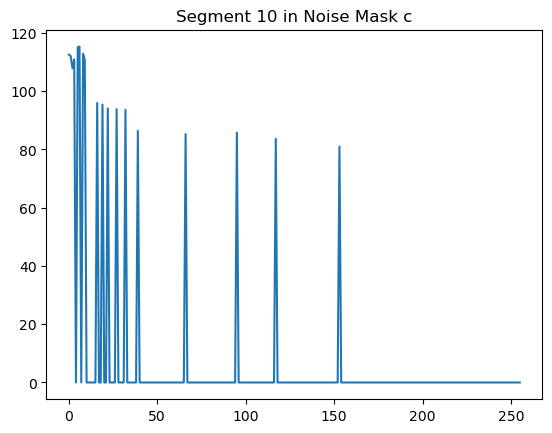

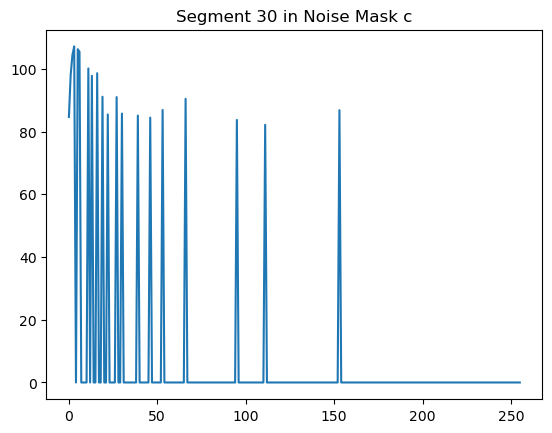

In [38]:
P_NMc = np.load(os.path.join(cwd, 'P_NMc-23.npy'))
P_TMc = np.load(os.path.join(cwd, 'P_TMc-23.npy'))

P_TMc = np.transpose(P_TMc)
P_NMc = np.transpose(P_NMc)

plt.figure(1)
plt.title("Segment 10 in Tone Mask c")
plt.plot((P_TMc[9]))

plt.figure(2)
plt.title("Segment 30 in Tone Mask c")
plt.plot((P_TMc[29]))

plt.figure(3)
plt.title("Segment 10 in Noise Mask c")
plt.plot((P_NMc[9]))

plt.figure(4)
plt.title("Segment 30 in Noise Mask c")
plt.plot((P_NMc[29]))

plt.show()


***Βήμα 1.4:*** Υπολογισμός των δυο διαφορετικών κατωφλίων κάλυψης (Individual Masking Thresholds)


Υπολογίζουμε τα δύο κατώφλια που δείχνουν το ποσοστό κάλυψης στη συχνότητα i από τη μάσκα τόνου ή θορύβου στη συχνότητα j. Η συνάρτηση SF(i, j) εκτιμά το ελάχιστο επίπεδο ισχύος που πρέπει να έχουν οι γειτονικές συχνότητες για να είναι αντιληπτές από τον άνθρωπο. Στον κώδικά μας κάνουμε comment out την εντολή print(k), την οποία χρησιμοποιούμε για να ελέγξουμε την ορθότητα του κώδικα, ωστόσο δεν αποτελεί ζητούμενο της άσκησης. Επιπλέον, έχουμε κάνει comment out την εντολή print("Done"), η οποία σηματοδοτεί την ολοκλήρωση της εκτέλεσης του κώδικα.

In [39]:
def B(i):
    value_b = i * sample_rate / window_size
    return 13 * np.arctan(0.00076 * value_b) + 3.5 * np.arctan((value_b / 7500) ** 2)


def DB(i, j):
    return B(i) - B(j)


def SF(P_Mask, i, j):
    def DB(i, j):
        return B(i) - B(j)

    DB = DB(i, j)

    if -3 <= DB < -1:
        return 17 * DB - 0.4 * P_Mask[j] + 11
    if -1 <= DB < 0:
        return (0.4 * P_Mask[j] + 6) * DB
    if 0 <= DB < 1:
        return -17 * DB
    if 1 <= DB < 8:
        return (0.15 * P_Mask[j] - 17) * DB - 0.15 * P_Mask[j]

    return "Error"


def T_TM(P_TM, i, j):
    return P_TM[j] - 0.275 * B(j) + SF(P_TM, i, j) - 6.025


def T_NM(P_NM, i, j):
    return P_NM[j] - 0.175 * B(j) + SF(P_NM, i, j) - 2.025


T_TM_ = []
T_NM_ = []
counter = 0


for k in range(len(P_TM)):
    temp_t = []
    double_temp_t = []
    for i in range(256):
        temp_t = []
        for j in range(256):
            if P_TMc[k][j] == 0:  # -------------------------------------------------------
                temp_t.append(0)
                continue
            if B(i) < B(j) - 3 or B(i) > B(j) + 8:
                temp_t.append(0)
                continue  # ----------------------------------------------------
            if k == 10:
                counter += 1
            temp_t.append(T_TM(P_TMc[k], i, j))
        double_temp_t.append(temp_t)
    T_TM_.append(double_temp_t)

    double_temp_n = []
    for i in range(256):
        temp_n = []
        for j in range(256):
            if P_NMc[k][j] == 0:  # ----------------------------------------------------
                temp_n.append(0)
                continue
            if B(i) < B(j) - 3 or B(i) > B(j) + 8:
                temp_n.append(0)
                continue  # -------------------------------------------------------
            temp_n.append(T_NM(P_NMc[k], i, j))
        double_temp_n.append(temp_n)
    T_NM_.append(double_temp_n)
    # print(k)
    
print("Done")

Done


***Βήμα 1.5:***  Υπολογισμός του συνολικού κατωφλίου κάλυψης (Global Masking Threshold)

Χρησιμοποιώντας τα κατώφλια που υπολογίστηκαν στο προηγούμενο ερώτημα, μπορούμε να υπολογίσουμε το Global Masking Threshold. Εκτυπώνουμε τα 10th και 30th segments του παραθυροποιημένου σήματος, προκειμένου να διαβεβαιώσουμε την ορθότητα του κώδικά μας.

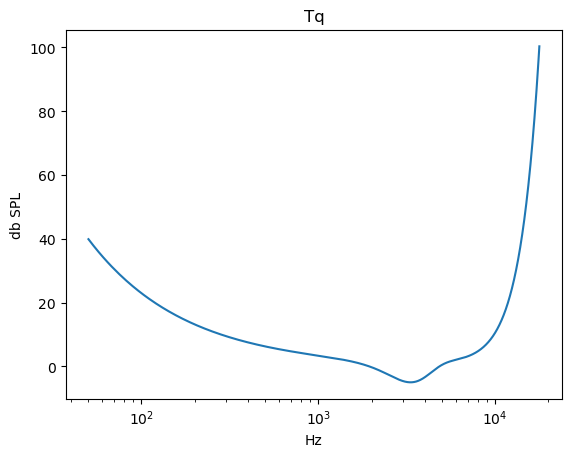

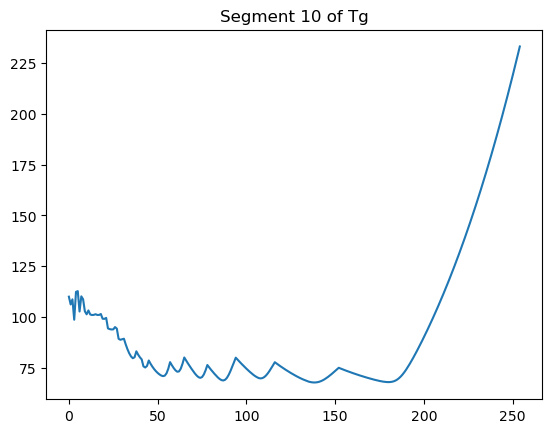

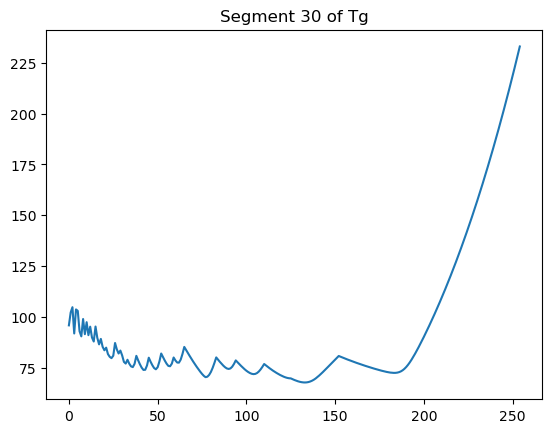

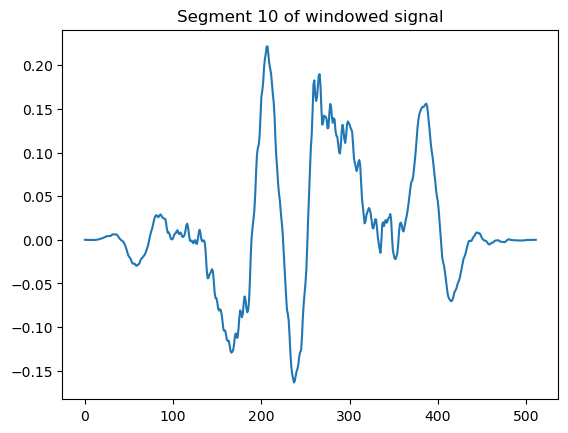

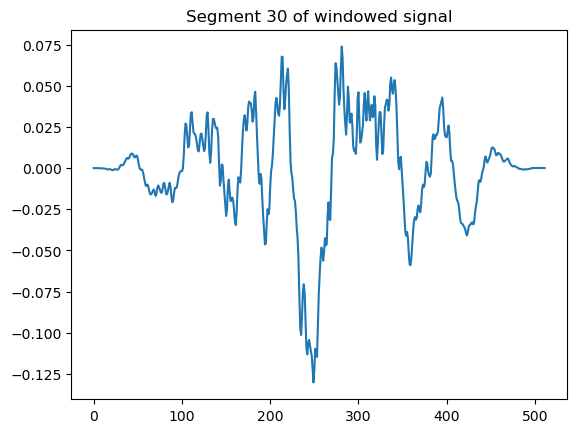

In [51]:
def T_q(i):
    value_Tq = i * sample_rate / window_size
    return 3.64 * ((value_Tq / 1000) ** (-0.8)) - 6.5 * np.exp(-0.6 * (((value_Tq / 1000) - 3.3) ** 2)) + (10 ** (-3)) * (
                value_Tq / 1000) ** 4

def T_g(i, T_TM, T_NM, P_TMc, P_NMc):
    sum1, sum2 = 0, 0
    for l in range(len(T_TM[i])):
        if P_TMc[l] != 0:
            sum1 += 10 ** (0.1 * T_TM[i][l])

    for m in range(len(T_NM[i])):
        if P_NMc[m] != 0:
            sum2 += 10 ** (0.1 * T_NM[i][m])

    return 10 * np.log10(10 ** (0.1 * T_q(i)) + sum1 + sum2)

T_g_ = [[T_g(i, T_TM_[k], T_NM_[k], P_TMc[k], P_NMc[k]) for i in range(1, len(P_TMc[k]))] for k in range(len(P_TMc) - 1)]

np.save("T_g_i.npy", T_g_)

freqs = np.linspace(10**(1.7), 10**(4.25), 5000)
T_q = [3.64 * math.pow(f / 1000, -0.8) - 6.5 * np.exp(-0.6 * math.pow(f / 1000 - 3.3, 2)) + 1 / 1000 * math.pow(f / 1000, 4) for f in freqs]


plt.xscale('log')
plt.title('Tq')
plt.xlabel('Hz')
plt.ylabel('db SPL')
plt.plot(freqs, T_q)
plt.show()

plt.figure()
plt.title("Segment 10 of Tg")
plt.plot(T_g_[9])
plt.show()

plt.figure()
plt.title("Segment 30 of Tg")
plt.plot(T_g_[29])
plt.show()

plt.figure()
plt.title("Segment 10 of windowed signal")
plt.plot(windowed_frames[9])

plt.figure()
plt.title("Segment 30 of windowed signal")
plt.plot(windowed_frames[29])

plt.show()